In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import matplotlib.tri as tri
import pandas as pd
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable

### constants

In [2]:
V_drt = 1.0
V_train = 2
delta = 1.0
ell = 1.0
t_w = 0.5
mu = 2
L = 10

In [3]:
#Generate N requests with origin and destinations

def get_req(N):
    x_o = np.random.uniform(0,L,N)
    x_d = np.random.uniform(0,L,N)
    y_o = np.random.uniform(0,L,N)
    y_d = np.random.uniform(0,L,N)
    return x_o,y_o,x_d,y_d

# Unimodal distance
def get_dist_uni(x_o,y_o,x_d,y_d):
    return delta*np.sqrt((x_o-x_d)**2 + (y_o-y_d)**2)

get_dist_uniVectorized = np.vectorize(get_dist_uni)

#Unimodal time
def get_t_uni(x_o,y_o,x_d,y_d):
    t = t_w + get_dist_uni(x_o,y_o,x_d,y_d)/V_drt
    return t

get_t_uniVectorized = np.vectorize(get_t_uni)

#Gives the location of train nearest to any point x,y on a grid.
def get_train(x,y):
    x_cell,x_grid = np.modf(x)
    y_cell,y_grid = np.modf(y)
    
    x_grid_1=x_grid+np.sign(x)
    y_grid_1=y_grid+np.sign(y)
    
    #get the station closest to given point in a cell
    d00 = get_dist_uni(x,y,x_grid,y_grid)
    d01 = get_dist_uni(x,y,x_grid,y_grid_1)
    d10 = get_dist_uni(x,y,x_grid_1,y_grid)
    d11 = get_dist_uni(x,y,x_grid_1,y_grid_1)
    
    d = np.array([d00,d01,d10,d11])
    loc = np.argmin(d)
    
    if loc==0:
        rt = x_grid,y_grid
    if loc==1:
        rt = x_grid,y_grid_1
    if loc==2:
        rt = x_grid_1,y_grid
    if loc==3:
        rt = x_grid_1,y_grid_1
    
    return rt

get_trainVectorized = np.vectorize(get_train)

# Bimodal transit time
def get_t_bi(x_o,y_o,x_d,y_d):
#    get nearest origin train station:
    x_o_train,y_o_train = get_train(x_o,y_o)
    
#    get nearest destination train station:
    x_d_train,y_d_train = get_train(x_d,y_d)
    
    t_uni_o = get_t_uni(x_o,y_o,x_o_train,y_o_train)
    t_uni_d = get_t_uni(x_d,y_d,x_d_train,y_d_train)
    t_train = (abs(x_o_train - x_d_train) + abs(y_o_train - y_d_train))/V_train + 1/(2.0*mu)
    
    t_bi = t_uni_o + t_uni_d + t_train
    
    return t_bi,x_o_train,y_o_train,x_d_train,y_d_train,t_train,t_uni_o,t_uni_d

get_t_biVectorized = np.vectorize(get_t_bi)


In [4]:
N = int(1E5)
x_o,y_o,x_d,y_d = get_req(N)
dist = np.sqrt((x_o-x_d)**2 + (y_o-y_d)**2)
total_dist = np.sum(dist)

#compute average distance
avg_dist = total_dist/N
print(avg_dist)
t_uni = get_t_uniVectorized(x_o,y_o,x_d,y_d)
t_bi,x_o_train,y_o_train,x_d_train,y_d_train,t_train,t_uni_o,t_uni_d = get_t_biVectorized(x_o,y_o,x_d,y_d)
t_bi = t_bi/t_uni
x = (x_d - x_o)/avg_dist #normalize with average distance
y = (y_d - y_o)/avg_dist #normalize with average distance

5.226979368877269


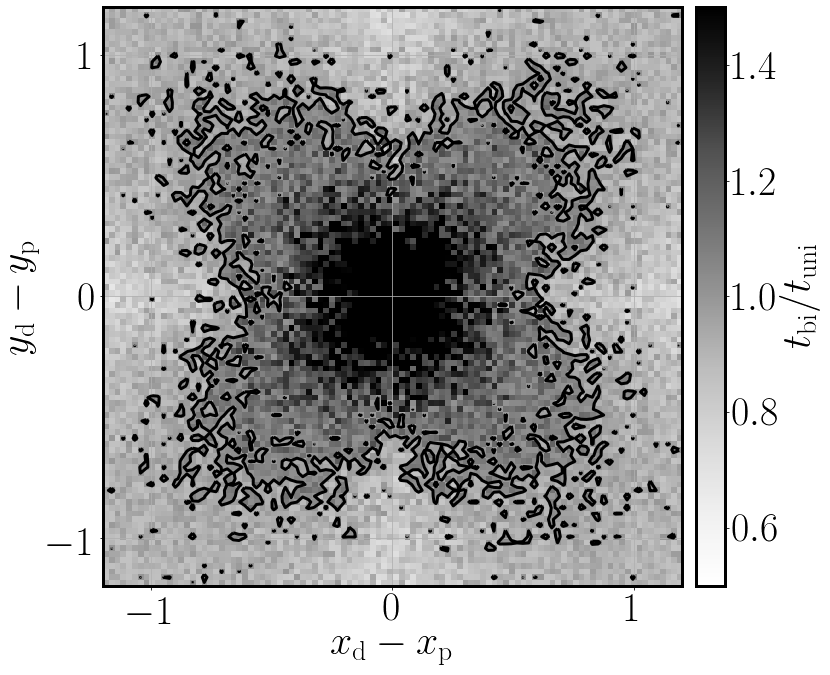

In [5]:
fig_width_pt = 1.0*128.0 # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27 # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0 # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height =1.2 * fig_width * golden_mean # height in inches
fig_size = [fig_width,fig_height]
params = {'backend': 'ps',
'axes.labelsize': 40,
'lines.markersize':15,
#'text.fontsize': 10,
'legend.fontsize': 55,
'legend.frameon': False,
'legend.numpoints': 1,
'xtick.labelsize': 40,
'ytick.labelsize': 40,
'text.usetex': True,
'axes.linewidth': 3.0,
'figure.figsize': fig_size,
'axes.titlesize': 40,
}
matplotlib.rcParams.update(params)
matplotlib.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']

#range of x and y axes on plot
end = 1.2
ticks = np.arange(-1,2)
plt.rcParams.update({'font.size': 22})
beta = 1/6*(np.sqrt(2)+np.log(1+np.sqrt(2)))

#Our theoretical prediction of d_c
d_c = 2*beta*delta/(delta-(4/np.pi)*(V_drt/V_train))
d_c += 2/(mu*(delta/V_drt - 4/(np.pi*V_train)))
d_c += t_w/(delta/V_drt - 4/(np.pi*V_train))
d_c = d_c/avg_dist


theta = np.linspace(0,2*np.pi,100)
#x_circle = d_c*np.cos(theta)
#y_circle = d_c*np.sin(theta)

#interpolate the data
from scipy.interpolate import griddata
fig,axs = plt.subplots(1,1,figsize=(12,12))
points = np.dstack((x,y))
values = t_bi
xx = np.linspace(-end,end,100)
yy = np.linspace(-end,end,100)
grid_x1,grid_y1 = np.meshgrid(xx,yy)
grid_z2_1 = griddata(points[0], t_bi, (grid_x1, grid_y1), method='nearest')

#plot the data
im = axs.imshow(grid_z2_1.T,vmin=0.5,vmax=1.5,extent=[-end,end,-end,end],cmap='Greys')
axs.contour(grid_z2_1.T, levels=[1.0], colors='black', origin='upper', extent=[-end,end,-end,end],linewidths=3)
#axs.plot(x_circle,y_circle,ls='dotted',color='white',lw=6)
axs.set_xlabel(r'$x_\mathrm{d}-x_\mathrm{p}$',fontsize=40)
axs.set_ylabel(r'$y_\mathrm{d}-y_\mathrm{p}$',fontsize=40)
axs.set_xlim(-end,end)
axs.set_ylim(-end,end)
axs.set_xticks(ticks)
axs.set_yticks(ticks)
axs.grid(visible=True)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax,label=r'$t_\mathrm{bi}/t_\mathrm{uni}$')
axs.set_aspect('equal')
plt.tight_layout()
#plt.title('fitting-coarse-contour',fontsize=20)
plt.savefig('coarse_contour.pdf')

### Emissions

In [6]:
#emission values from Knut's litterature

emi_train_elec = 27
emi_train_diesel = 70
emi_car_diesel = 686
emi_shuttle_diesel = 911
emi_car_elec = 184
emi_shuttle_elec = 259


k = 100    
eta = 1.2
L=10
N = int(1E5)
x_o,y_o,x_d,y_d = get_req(N)
total_distance = np.sum(np.sqrt((x_o-x_d)**2 + (y_o-y_d)**2))
avg_dist = total_distance/N
train_emission = 4*mu*k*emi_train_elec

def get_bi_emissions(x_o,y_o,x_d,y_d):
    #    get nearest origin train station:
    x_o_train,y_o_train = get_train(x_o,y_o)
    
    #    get nearest destination train station:
    x_d_train,y_d_train = get_train(x_d,y_d)
    
    drt_bi_dist = np.sqrt((x_d_train-x_d)**2 + (y_d_train-y_d)**2) + np.sqrt((x_o_train-x_o)**2 + (y_o_train-y_o)**2)
    
    drt_bi_emission = emi_shuttle_diesel*drt_bi_dist/eta
    
    total_bi_emission = drt_bi_emission # + train_emission (don't need to add this we only report change due to one user)
    
    drt_only_emission = np.sqrt((x_d-x_o)**2+(y_d-y_o)**2)*emi_shuttle_diesel/eta
    
    total_drt_only_emission = drt_only_emission# + train_emission
    
    return total_bi_emission/(total_drt_only_emission)


get_bi_emissionsVectorized = np.vectorize(get_bi_emissions)

emission_bi = get_bi_emissionsVectorized(x_o,y_o,x_d,y_d)
x = (x_d - x_o)/avg_dist
y = (y_d - y_o)/avg_dist

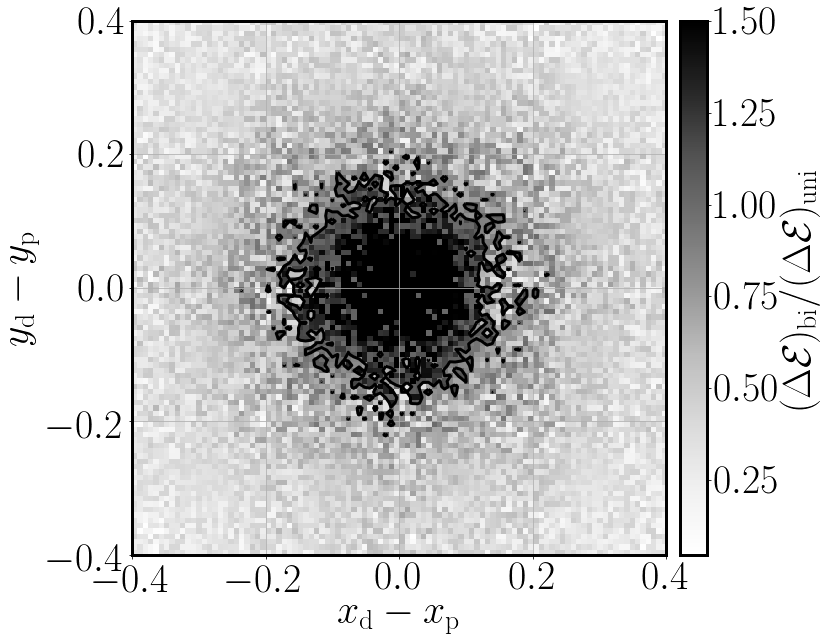

In [7]:
fig_width_pt = 1.0*128.0 # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27 # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0 # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height =1.2 * fig_width * golden_mean # height in inches
fig_size = [fig_width,fig_height]
params = {'backend': 'ps',
'axes.labelsize': 40,
'lines.markersize':15,
#'text.fontsize': 10,
'legend.fontsize': 55,
'legend.frameon': False,
'legend.numpoints': 1,
'xtick.labelsize': 40,
'ytick.labelsize': 40,
'text.usetex': True,
'axes.linewidth': 3.0,
'figure.figsize': fig_size,
'axes.titlesize': 40,
}
matplotlib.rcParams.update(params)
matplotlib.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']


end = 0.4
ticks = np.arange(-0.4,0.5,0.2)
plt.rcParams.update({'font.size': 22})
beta = 1/6*(np.sqrt(2)+np.log(1+np.sqrt(2)))
# d_c = 2*beta*delta/(delta-(4/np.pi)*(V_drt/V_train))
# d_c += 2/(mu*(delta/V_drt - 4/(np.pi*V_train)))
# d_c += t_w/(delta/V_drt - 4/(np.pi*V_train))
d_c = 2*beta
theta = np.linspace(0,2*np.pi,100)
x_circle = d_c*np.cos(theta)
y_circle = d_c*np.sin(theta)

from scipy.interpolate import griddata
fig,axs = plt.subplots(1,1,figsize=(12,12))
points = np.dstack((x,y))
values = emission_bi
xx = np.linspace(-end,end,100)
yy = np.linspace(-end,end,100)
grid_x,grid_y = np.meshgrid(xx,yy)
grid_z2 = griddata(points[0], values, (grid_x, grid_y), method='nearest')

im = axs.imshow(grid_z2.T,extent=[-end,end,-end,end],cmap='Greys',vmax=1.5)
axs.contour(grid_z2.T, levels=[1.0], colors='black', origin='upper', extent=[-end,end,-end,end],linewidths=3)
#axs.plot(x_circle,y_circle,ls='dotted',color='white',lw=6)
axs.set_xlabel(r'$x_\mathrm{d}-x_\mathrm{p}$',fontsize=40)
axs.set_ylabel(r'$y_\mathrm{d}-y_\mathrm{p}$',fontsize=40)
axs.set_xticks(ticks)
axs.set_yticks(ticks)
axs.grid(visible=True)
axs.set_xlim(-end,end)
axs.set_ylim(-end,end)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im,cax=cax,label=r'$(\Delta\mathcal{E})_\mathrm{bi}/(\Delta\mathcal{E})_\mathrm{uni}$')
axs.set_aspect('equal')
plt.tight_layout()
#plt.title('fitting-coarse-contour',fontsize=20)
plt.savefig('emission_contour.pdf')

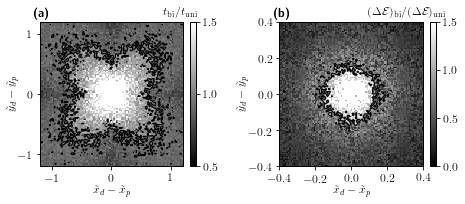

In [19]:
fig,axs = plt.subplots(1,2,figsize=(2*246.09686/72.27, 246.09686/72.27))

params = {
'backend': 'ps',
'axes.labelsize': 12,
'xtick.labelsize': 12,
'ytick.labelsize': 12,
'text.usetex': True,
'axes.linewidth': 1.0,
'figure.figsize': (2*246.09686/72.27, 246.09686/72.27),
'axes.titlesize': 12,
}

plt.rcParams.update(params)
matplotlib.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']


end = 0.4
ticks = np.arange(-0.4,0.5,0.2)
im1 = axs[1].imshow(grid_z2.T,extent=[-end,end,-end,end],cmap='gray',vmin = 0,vmax=1.5,zorder=2)
axs[1].contour(grid_z2.T, levels=[1.0], colors='black', origin='upper', extent=[-end,end,-end,end],linewidths=1.2,zorder=2.1)
#axs.plot(x_circle,y_circle,ls='dotted',color='white',lw=6)
axs[1].set_xlabel(r'$\tilde{x}_{d}-\tilde{x}_{p}$',labelpad=2)
axs[1].set_ylabel(r'$\tilde{y}_{d}-\tilde{y}_{p}$',labelpad=-1)
axs[1].set_xticks(ticks)
axs[1].set_yticks(ticks)
axs[1].grid(visible=True,zorder=0)
axs[1].set_xlim(-end,end)
axs[1].set_ylim(-end,end)
axs[1].set_title(r'\textbf{(b)}',x=0.02,zorder=12)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="4%", pad=0.1)
clb = plt.colorbar(im1,cax=cax,ticks=[0,0.5,1,1.5])
clb.ax.set_title(r'$(\Delta\mathcal{E})_\mathrm{bi}/(\Delta\mathcal{E})_\mathrm{uni}$',x=-4)

#plt.tight_layout()

end = 1.2
ticks = np.arange(-1,2)
#plot the data
im0 = axs[0].imshow(grid_z2_1.T,vmin=0.5,vmax=1.5,extent=[-end,end,-end,end],cmap='gray',zorder=2)
axs[0].contour(grid_z2_1.T, levels=[1.0], colors='black', origin='upper', extent=[-end,end,-end,end],linewidths=1.2,zorder=2.1)
#axs.plot(x_circle,y_circle,ls='dotted',color='white',lw=6)
axs[0].set_xlabel(r'$\tilde{x}_{d}-\tilde{x}_{p}$',labelpad=2)
axs[0].set_ylabel(r'$\tilde{y}_{d}-\tilde{y}_{p}$',labelpad=-1)
axs[0].set_xlim(-end,end)
axs[0].set_ylim(-end,end)
axs[0].set_xticks(ticks)
axs[0].set_yticks(ticks)
axs[0].grid(visible=True)
axs[0].set_title(r'\textbf{(a)}',x=0.02,zorder=12)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="4%", pad=0.1)
clb = plt.colorbar(im0, cax=cax,ticks=[0.5,1,1.5])
clb.ax.set_title(r'$t_\mathrm{bi}/t_\mathrm{uni}$',x=-1.8)

plt.tight_layout(pad=0.9)
#plt.title('fitting-coarse-contour',fontsize=20)
plt.savefig('contour_d_c.pdf')